In [2]:
import torch
import torch.nn as nn
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline

In [3]:
class KuramotoData(torch.utils.data.Dataset):
    
    def __init__(self, filename):
        with open(filename, 'r') as fp:
            self.data = json.load(fp)
        for data_point in self.data:
            data_point['g'] = self.adjlist2adjmtx(data_point['a'])
            data_point['w'] = np.asarray(data_point['w'])
            data_point['h'] = np.asarray(data_point['h'])
            
    def adjlist2adjmtx(self, adjlist):
        # adjlist, 0-indexed
        n = len(adjlist)
        res = np.zeros((n,n))
        for i, l in enumerate(adjlist):
            for j in l:
                res[i][j] = 1
        return res
    
    def __getitem__(self, idx):
        xy = self.data[idx]
        return (xy['g'], xy['w'], xy['h']), xy['ps']
    
    def __len__(self):
        return len(self.data)

In [4]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class KuramotoNN(torch.nn.Module):
    
    def __init__(self, N):
        super(KuramotoNN, self).__init__()
        self.N = N
        self.tmp = nn.Sequential(Flatten())
        self.graph_head = nn.Sequential(Flatten(), nn.Linear(N*N, 1024),nn.ReLU(), nn.BatchNorm1d(1024),
                                         nn.Linear(1024, 256),nn.ReLU(), nn.BatchNorm1d(256),
                                         nn.Linear(256,128),nn.ReLU())
        self.freq_head = nn.Sequential(nn.Linear(N, 128), nn.ReLU(), nn.BatchNorm1d(128),
                                      nn.Linear(128,64), nn.ReLU(), nn.BatchNorm1d(64),
                                      nn.Linear(64,32), nn.ReLU())
        self.regressor = nn.Sequential(nn.Linear(128+32, 64), nn.ReLU(), nn.BatchNorm1d(64),
                                      nn.Linear(64,16), nn.ReLU(), nn.Linear(16,1))
        #self.init_theta = notimplemented
    
    def forward(self, input):
        a, w = input
        x1 = self.graph_head(a)
        x2 = self.freq_head(w)
        res = self.regressor(torch.cat((x1, x2), dim=1))
        res = res.squeeze()
        return res
        

In [34]:
train_dataset = KuramotoData('./data_N20_U0x1_L0x4_w10_run1000.json')
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64)
test_dataset = KuramotoData('./data_N20_U0x1_L0x4_w10_run500.json')
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

In [35]:
net = KuramotoNN(20)
optm = torch.optim.Adam(net.parameters(), lr=0.0001)
crit = torch.nn.L1Loss()
epochs = 100

In [36]:
losses = []
testloss = []
net.train()
for e in tqdm(range(epochs)):
    for x,y in train_dataloader:
        net.zero_grad()
        yhat = net((x[0].float(), x[1].float()))
        loss = crit(yhat, y.float())
        loss.backward()
        optm.step()
        losses.append(loss.item())
    gen_eval(net, test_dataloader) 

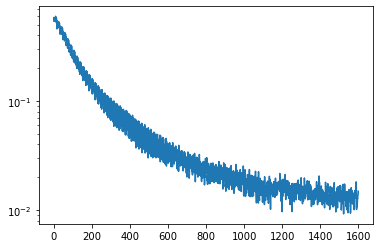

In [37]:
plt.semilogy(losses)

In [39]:
def gen_eval(net, dLoader):
    cnt, res = 0, 0
    pred, gt = [], []
    for x, y in dLoader:
        z = net((x[0].float(), x[1].float()))
        z = z.detach().cpu().numpy()
        cnt += len(y)
        res += sum(np.abs(y.float().numpy()-z))
        pred.extend(z.tolist())
        gt.extend(y.numpy().tolist())
    return res, cnt, pred, gt
    

In [212]:
res, cnt, res/cnt, len(pred), len(gt)

(669775.9518432617, 1000, 669.7759518432617, 1000, 1000)

In [196]:
print(res/cnt)

7.488503019332886


Text(0.5, 1.0, '0.18278630262613296')

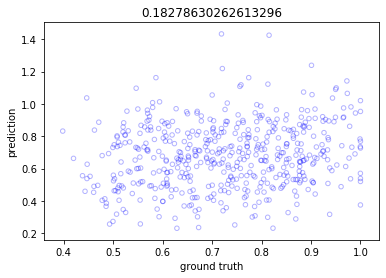

In [40]:
res, cnt, pred, gt = gen_eval(net, test_dataloader)
plt.scatter(gt, pred, s=20, marker='o', facecolor='none', edgecolor='b', alpha=0.3)
plt.xlabel('ground truth')
plt.ylabel('prediction')
plt.title(str(res/cnt))
#plt.xlim([0.2,1])
#plt.ylim([0.2,1])

Text(0.5, 1.0, '0.010528905600309372')

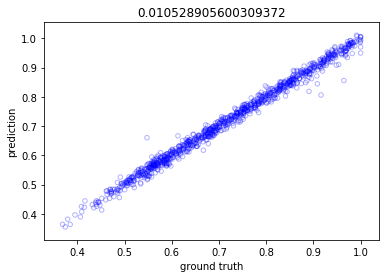

In [41]:
res, cnt, pred, gt = gen_eval(net, train_dataloader)
plt.scatter(gt, pred, s=20, marker='o', facecolor='none', edgecolor='b', alpha=0.3)
plt.xlabel('ground truth')
plt.ylabel('prediction')
plt.title(str(res/cnt))
#plt.xlim([0.2,1])
#plt.ylim([0.2,1])

In [96]:
tmp1 = torch.rand((3,4))
tmp2 = torch.rand((3,2))

In [70]:
torch.cat([tmp1, tmp2],1)

tensor([[0.6150, 0.1479, 0.0457, 0.5200, 0.2767, 0.2204],
        [0.6458, 0.4026, 0.8597, 0.1714, 0.6759, 0.7641],
        [0.3335, 0.7305, 0.4387, 0.3359, 0.0434, 0.6973]])

In [67]:
tmp1.shape, tmp2.shape

(torch.Size([3, 4]), torch.Size([3, 2]))

In [55]:
for x,y in dataloader:
    print(type(x[0]), type(x[1]), type(x[2]), type(y))
    print(x[0].shape)
    print(y)
    break

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([5, 20, 20])
tensor([0.6494, 0.5803, 0.6901, 0.6693, 0.4228], dtype=torch.float64)


In [31]:
list(dataset.data[0].keys())

['a', 'w', 'h', 'r', 'ps', 'g']

In [173]:
sum(p.numel() for p in net.parameters())

733377